# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]

# Filtering to only include correlation values higher than |0.35|
cols_corr_filtered = correlations[(correlations > 0.3) | (correlations < -0.3)]
cols_corr_filtered.sort_values()
print(cols_corr_filtered)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF LARGEST CLASS                   0.314434
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_percent                            -0.398750
sped_percent                           -0.448170
asian_num                               0.475445
asian_per                               0.570730
hispanic_per                           -0.396985
white_num                               0.449559
white_per           

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as axe1

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


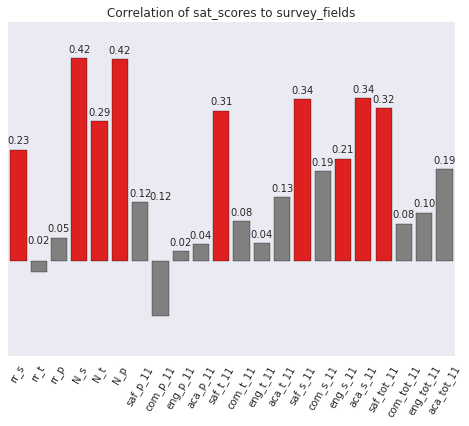

In [12]:
%matplotlib inline
# Setting figure size
plt.figure(figsize=(8,6))
# Highlights survey_fields that have a correlation above 0.2
bar_color = ['grey' if (abs(x) < 0.2) else 'red' for x in correlations[survey_fields].values ]
ax = sns.barplot(x = correlations[survey_fields].index, y = correlations[survey_fields].values, palette = bar_color)

ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(left = False, bottom = False)
plt.xticks(rotation=60)
ax.set_yticks([])

#Annotating the bargraph
for p in ax.patches:
    corr_val = '{:.2f}'.format(p.get_height())
    x = p.get_x()+p.get_width()/2.
    y = p.get_height()
    ax.annotate(corr_val,(x,y),
                ha='center',
                va='center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
    
ax.set_title("Correlation of sat_scores to survey_fields")
plt.show()

Number of parent respondents (N_p) and number of student respondents (N_s) show a very high positive correlation with SAT scores. Possibly indicating that involvment from parents and students could lead to higher scores. 

Another considersation is safety scores also correlate well with SAT scores. I'll produce a scatterplot of one of the perceived safety columns with SAT score next. 

<function matplotlib.pyplot.show>

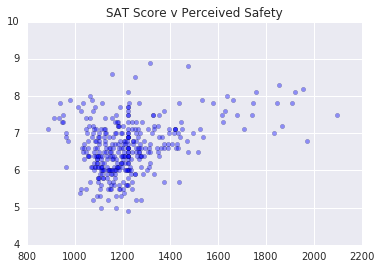

In [13]:
plt.scatter(combined['sat_score'], combined['saf_s_11'], alpha = 0.4)
plt.title("SAT Score v Perceived Safety")
plt.show   

There may be a slight positive trend between percieved student safety and SAT score. However, most of the scores seem to be clustered between 5 and 7 for perceived safety and 1000-1400 SAT scores. 

<function matplotlib.pyplot.show>

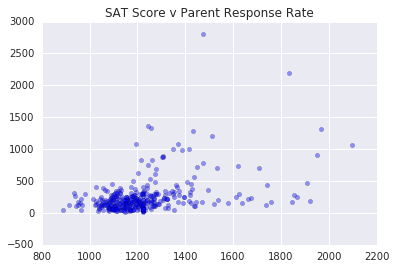

In [14]:
plt.scatter(combined['sat_score'], combined['N_p'], alpha = 0.4)
plt.title("SAT Score v Parent Response Rate")
plt.show   

The scatterplot of response rate above vs SAT score isn't quite as enlightening as we had hoped. Zooming in on the image may show more of a trend...but we'll leave that for now. 

In [28]:
combined["borough"] = combined["DBN"].apply(lambda dbn: dbn[2])
borough_avg = combined.groupby("borough").agg(numpy.mean)
print('\033[1m' + "Safety Scores across boroughs in ascending order of Safety Score" + '\033[0m')
borough_avg['saf_s_11'].sort_values()

Safety Scores across boroughs in ascending order of Safety Score


borough
K    6.370755
R    6.530000
X    6.606577
Q    6.721875
M    6.831370
Name: saf_s_11, dtype: float64

The code representing each borough is Brooklyn (K), Bronx (X), Queens (Q), Manhattan (M), Staten Island (R). Above the data is displayed in ascending order. Manhattan is the safest, but the spread of the safety scores is not that wide. 

#### Moving on to race evaluation

In [32]:
race = ['white_per', 'asian_per', 'black_per','hispanic_per']
print("Correlation of SAT score and the different races of students")
correlations[race]

Correlation of SAT score and the different races of students


white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

It looks like there is a pretty strong positive correlation in test score with white and Asian students. Sadly, it looks as though there's a strong negative correlation with Black and Hispanic students. 

<function matplotlib.pyplot.show>

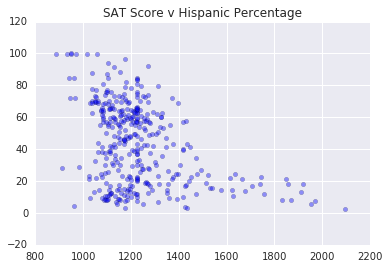

In [33]:
plt.scatter(combined['sat_score'], combined['hispanic_per'], alpha = 0.4)
plt.title("SAT Score v Hispanic Percentage")
plt.show

It looks like the higher the hispanic percentage, the lower the scores seem to concentrate. 

In [35]:
high_hisp = combined[combined['hispanic_per'] > 95]

In [39]:
high_hisp[['SCHOOL NAME', 'sat_score']]

,SCHOOL NAME,sat_score
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0
253,MULTICULTURAL HIGH SCHOOL,887.0
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0


In [44]:
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)][['SCHOOL NAME', 'sat_score']]

,SCHOOL NAME,sat_score
37,STUYVESANT HIGH SCHOOL,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0


In [51]:
correlations['female_per']

0.11210773942203284

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


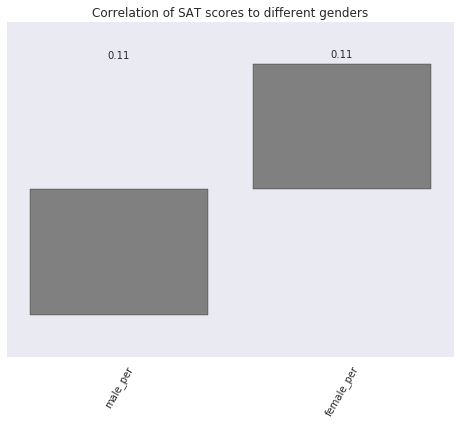

In [50]:
plt.figure(figsize=(8,6))
gender = ['male_per', 'female_per']
# Highlights survey_fields that have a correlation above 0.2
bar_color = ['grey' if (abs(x) < 0.2) else 'red' for x in correlations[gender].values ]
ax = sns.barplot(x = correlations[gender].index, 
                 y = correlations[gender].values, 
                 palette = bar_color)

ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(left = False, bottom = False)
plt.xticks(rotation=60)
ax.set_yticks([])

#Annotating the bargraph
for p in ax.patches:
    corr_val = '{:.2f}'.format(p.get_height())
    x = p.get_x()+p.get_width()/2.
    y = p.get_height()
    ax.annotate(corr_val,(x,y),ha='center',va='center', xytext = (0, 9), 
                   textcoords = 'offset points')
    
ax.set_title("Correlation of SAT scores to different genders")
plt.show()

Both correlations are low, but females are positively correlated and males are negatively correlated. 

<function matplotlib.pyplot.show>

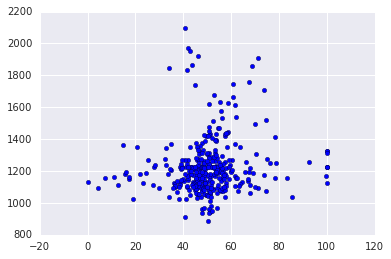

In [52]:
plt.scatter(combined['female_per'], combined['sat_score'])
plt.show

There does seem to be some correlation with higher percentage of female students and higher SAT scores. 

In [56]:
combined[(combined['female_per'] > 60) &
         (combined['sat_score']>1700)][['SCHOOL NAME', 'sat_score', 'female_per']]

,SCHOOL NAME,sat_score,female_per
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,68.7
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,67.5
60,BEACON HIGH SCHOOL,1744.0,61.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,73.6
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0,71.1


In [57]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

<function matplotlib.pyplot.show>

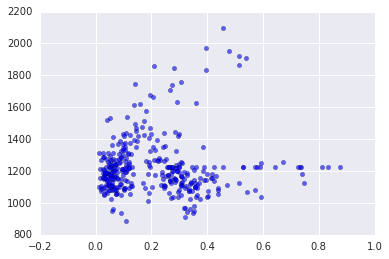

In [58]:
plt.scatter(combined['ap_per'], combined['sat_score'], alpha = 0.6)
plt.show

There is a positive correlation between the percentage of students taking AP tests and SAT scores. 